In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm shap joblib optuna imbalanced-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 7.2 MB/s eta 0:00:00


In [5]:
#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modeling and preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna
import shap

#saving model
import joblib

#warnings
import warnings
warnings.filterwarnings('ignore')


In [7]:
#upload json key
from google.colab import files
files.upload()

#clear output
from IPython.display import clear_output
clear_output()
print("Upload successful and output cleared.")

#save file to /.kaggle with correct permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload successful and output cleared.


In [8]:
# Download the dataset and unzip
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.95GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [10]:
#load dataset
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
#download file to laptop
df.to_csv("fraud_output.csv", index=False)

from google.colab import files
files.download("fraud_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#data overview
print(f"shape: ",df.shape)
print(df['Class'].value_counts())
print('\nPercentage fraud: {:.4f}%'.format(100*df['Class'].mean()))
df.info()

shape:  (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64

Percentage fraud: 0.1727%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-n

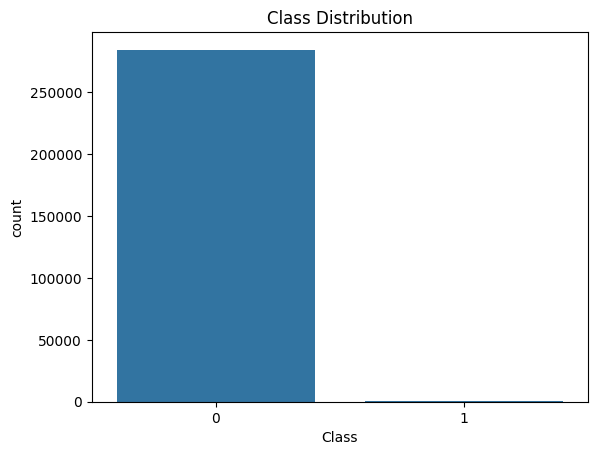

In [13]:
#EDA - class distribution
sns.countplot(x='Class',data=df)
plt.title('Class Distribution')
plt.show()


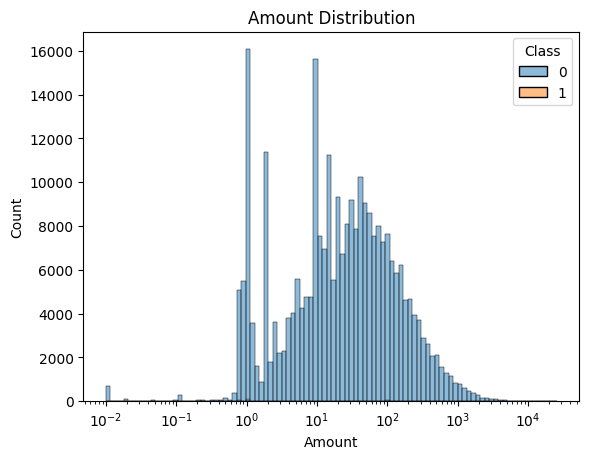

In [22]:
#feature distribution
sns.histplot(data=df,x='Amount',hue='Class',log_scale=True,bins=100)
plt.title('Amount Distribution')
plt.show()

In [23]:
#feature selection
X = df.drop(['Time','Class'],axis=1)
y = df['Class']

In [24]:
#Train-Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [31]:
#Preprocessing Pipeline
num_features = X_train.columns


#Pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features)
])

In [32]:
#Modeling Pipeline with SMOTE
pipeline= ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote',SMOTE(random_state=42)),
    ('model',LGBMClassifier(n_jobs=1,random_state=42))
])

In [33]:
#Optuna Tuning
def objective(trial):
  params={
      'n_estimators':trial.suggest_int('n_estimators',100,500),
      'max_depth':trial.suggest_int('max_depth',3,10),
      'learning_rate':trial.suggest_float('learning_rate',0.01,0.4),
      'num_leaves':trial.suggest_int('num_leaves',20,300),
      'min_child_samples':trial.suggest_int('min_child_samples',10,100),
      'subsample':trial.suggest_float('subsample',0.6,1.0),
      'colsample_bytree':trial.suggest_float('colsample_bytree',0.6,1.0),
      'reg_alpha':trial.suggest_float('reg_alpha',0.0,5.0),
      'reg_lambda':trial.suggest_float('reg_lambda',0.0,5.0)
  }

  clf = ImbPipeline(steps=[
      ('preprocessor',preprocessor),
      ('smote',SMOTE(random_state=42)),
      ('model',LGBMClassifier(**params,n_jobs=1,random_state=42))
  ])

  #scoring='average_precision'
  #Area Under the Precision-Recall Curve (AUPRC) — Kaggle has recommended imbalanced classification problems

  skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  score = cross_val_score(clf,X_train,y_train,cv=skf,scoring='average_precision',n_jobs=-1)
  return score.mean()

AUC-ROC can be misleading (it treats both classes equally).

AUPRC ('average_precision') focuses more on how well you identify the minority (fraud) class — which is our real interest.

In [34]:
#Study
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=30)
best_params = study.best_params
print(best_params)

[I 2025-07-18 08:08:11,751] A new study created in memory with name: no-name-9d7249fd-cb6d-49e9-ac95-1e820d7e5cc2
[I 2025-07-18 08:09:03,295] Trial 0 finished with value: 0.8441930458585283 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.19659436983069525, 'num_leaves': 86, 'min_child_samples': 79, 'subsample': 0.8900112435644874, 'colsample_bytree': 0.7727583949778675, 'reg_alpha': 0.07346495424984223, 'reg_lambda': 4.183441926510564}. Best is trial 0 with value: 0.8441930458585283.
[I 2025-07-18 08:10:07,909] Trial 1 finished with value: 0.8507525559606804 and parameters: {'n_estimators': 392, 'max_depth': 10, 'learning_rate': 0.31472397402469265, 'num_leaves': 94, 'min_child_samples': 69, 'subsample': 0.6701856726306243, 'colsample_bytree': 0.9261134214049683, 'reg_alpha': 0.199290133344035, 'reg_lambda': 0.6863691262890881}. Best is trial 1 with value: 0.8507525559606804.
[I 2025-07-18 08:11:37,264] Trial 2 finished with value: 0.8384791947206054 and parame

{'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.14894054820176908, 'num_leaves': 149, 'min_child_samples': 93, 'subsample': 0.9978672924751126, 'colsample_bytree': 0.9117467264842741, 'reg_alpha': 0.3949685966765586, 'reg_lambda': 4.5735228972897275}


In [35]:
print(best_params)

{'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.14894054820176908, 'num_leaves': 149, 'min_child_samples': 93, 'subsample': 0.9978672924751126, 'colsample_bytree': 0.9117467264842741, 'reg_alpha': 0.3949685966765586, 'reg_lambda': 4.5735228972897275}


In [40]:
best_trial = study.best_trial.value
print('average_precission: ',best_trial)

average_precission:  0.8566660424142791


In [41]:
#Build Final Pipeline with Best Params
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LGBMClassifier(**best_params, n_jobs=1, random_state=42))
])

In [43]:
#Cross-Validated Predict Proba
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
y_proba = cross_val_predict(final_pipeline,X_train,y_train,cv=skf,method='predict_proba',n_jobs=-1)[:,1]

In [44]:
# Compute AUPRC (Average Precision)
from sklearn.metrics import average_precision_score
auprc = average_precision_score(y_train, y_proba)
print('AUPRC:', auprc)

AUPRC: 0.8562630565363144


In [47]:
#Tune Threshold
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train, y_proba)

# Compute F1 for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

#Best threshold
best_index = f1_scores.argmax()
best_threshold = thresholds[best_index]
print("Best Threshold:", best_threshold)

Best Threshold: 0.9821392069976014


In [55]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

y_pred = (y_proba >= best_threshold).astype(int) # y_pred_proba >= optimal_threshold gives Boolean, hence making int

print('classification_report: \n',classification_report(y_train, y_pred))
print('confusion_matrix: \n', confusion_matrix(y_train, y_pred))
print('auprc: \n',average_precision_score(y_train, y_pred))

classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.94      0.79      0.86       394

    accuracy                           1.00    227845
   macro avg       0.97      0.90      0.93    227845
weighted avg       1.00      1.00      1.00    227845

confusion_matrix: 
 [[227432     19]
 [    82    312]]
auprc: 
 0.7467828238409651


Precision (fraud) = 0.94 → When the model says fraud, it's correct 94% of the time.

Recall (fraud) = 0.79 → It catches 79% of the actual frauds.

F1-score (fraud) = 0.86 → Balance of precision and recall is quite strong.

SHAP Explainability

[LightGBM] [Info] Number of positive: 284315, number of negative: 284315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 568630, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

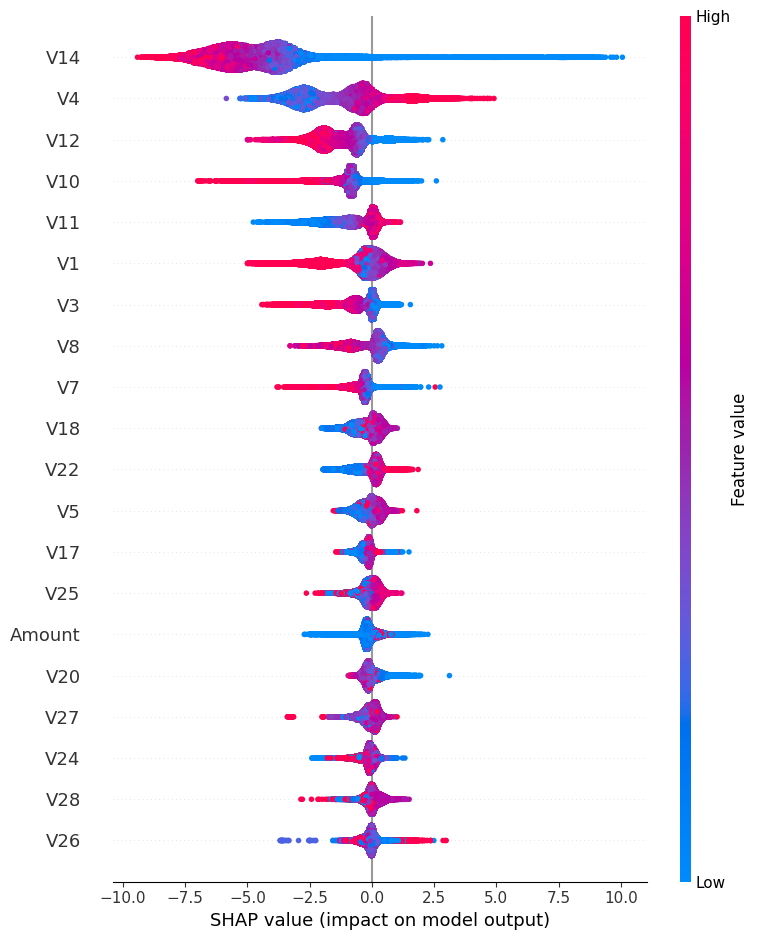

In [56]:
final_pipeline.fit(X,y)

X_transformed = final_pipeline.named_steps['preprocessor'].transform(X)
model = final_pipeline.named_steps['model']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed,feature_names=num_features)

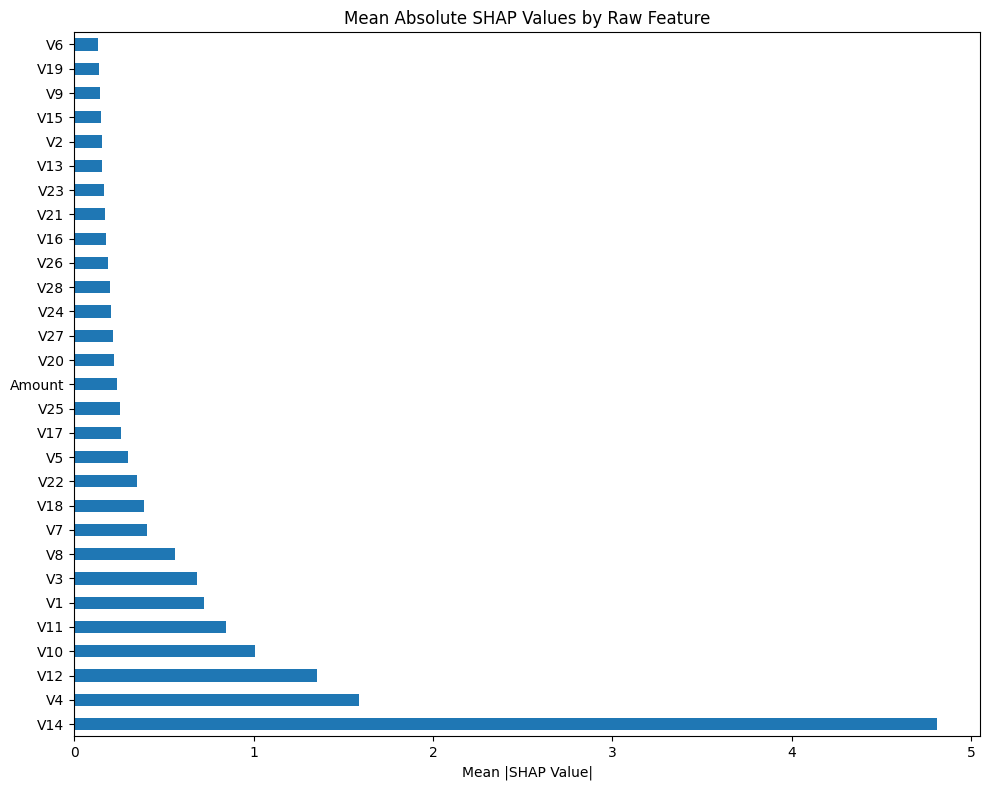

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

#get encoded feature names
encoded_feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

#convert shap_values[1] to dataframe class 1
shap_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values
shap_df = pd.DataFrame(shap_matrix, columns=encoded_feature_names)

#clean feature names
clean_feature_map = [col.split('__')[-1].split('_')[0] for col in shap_df.columns]
shap_df.columns = clean_feature_map

#Group by features and avg of importance(shap_values)
shap_grouped = shap_df.groupby(shap_df.columns,axis=1).mean()
mean_abs_shap = shap_grouped.abs().mean().sort_values(ascending=False)

#plot
plt.figure(figsize=(10, 8))
mean_abs_shap.plot(kind='barh')
plt.title("Mean Absolute SHAP Values by Raw Feature")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()

In [59]:
#extract default values for stremlit app, 50% features to have default values
import pandas as pd
num_cols = X.select_dtypes(include=['number']).columns

# Get median for numerical columns
default_num_values = X[num_cols].median()

print(default_num_values.to_dict())

{'V1': 0.0181087991615309, 'V2': 0.0654855563960555, 'V3': 0.179846343563544, 'V4': -0.0198465294811989, 'V5': -0.0543358267364858, 'V6': -0.274187076506651, 'V7': 0.0401030827945351, 'V8': 0.0223580364366631, 'V9': -0.051428731550349, 'V10': -0.0929173835961975, 'V11': -0.032757354499007, 'V12': 0.140032588291332, 'V13': -0.0135680567852071, 'V14': 0.0506013193100486, 'V15': 0.0480715497626106, 'V16': 0.0664133205843014, 'V17': -0.0656757538072252, 'V18': -0.0036363123546992, 'V19': 0.0037348229952574, 'V20': -0.0624810924603664, 'V21': -0.0294501676953819, 'V22': 0.0067819425282695, 'V23': -0.0111929302967212, 'V24': 0.0409760560572798, 'V25': 0.0165935016367397, 'V26': -0.0521391080182019, 'V27': 0.0013421459786502, 'V28': 0.011243831564982, 'Amount': 22.0}


In [62]:
import joblib

joblib.dump(final_pipeline, 'fraud_risk_pipeline.pkl')

joblib.dump(default_num_values,'median_values.pkl')

['median_values.pkl']

In [63]:
#Download to your local machine
from google.colab import files

# Download the model
files.download("fraud_risk_pipeline.pkl")

# Download the default median values
files.download("median_values.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
import json

threshold = best_threshold
with open("threshold.json", "w") as f:
    json.dump({"threshold": threshold}, f)

In [65]:
best_threshold

np.float64(0.9821392069976014)

In [66]:
#Download to your local machine
from google.colab import files

# Download the json
files.download("threshold.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>